### Imports

In [6]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# to process data for nn
from sklearn import preprocessing

### Load Data

In [2]:
with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/train_set/x_train.pickle", "rb") as file:
    x_train = pickle.load(file)

with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/train_set/y_train.pickle", "rb") as file:
    y_train = pickle.load(file)

with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/internal_test_set/internal_x_test.pickle", "rb") as file:
    internal_x_test = pickle.load(file)

with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/internal_test_set/internal_y_test.pickle", "rb") as file:
    internal_y_test = pickle.load(file)

with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/external_test_set/external_x_test.pickle", "rb") as file:
    external_x_test = pickle.load(file)

with open("../../../../data/1_all_active_random_inactive/2DRDKit/for_ml/external_test_set/external_y_test.pickle", "rb") as file:
    external_y_test = pickle.load(file)

### Params

In [16]:
nn_params = [
    {
        "layer_size": 200,
        "dropout": 0.0
    },
    {
        "layer_size": 500,
        "dropout": 0.0
    },
    {
        "layer_size": 750,
        "dropout": 0.0
    },
    {
        "layer_size": 1000,
        "dropout": 0.0
    },
    {
        "layer_size": 200,
        "dropout": 0.2
    },
    {
        "layer_size": 500,
        "dropout": 0.2
    },
    {
        "layer_size": 750,
        "dropout": 0.2
    },
    {
        "layer_size": 1000,
        "dropout": 0.2
    }
]

### Models

In [7]:
scaler = preprocessing.StandardScaler()

In [8]:
x_train_scaled = scaler.fit_transform(x_train)
internal_x_test_scaled = scaler.transform(internal_x_test)
external_x_test_scaled = scaler.transform(external_x_test)

x_train_scaled = np.nan_to_num(x_train_scaled)
internal_x_test_scaled = np.nan_to_num(internal_x_test_scaled)
external_x_test_scaled = np.nan_to_num(external_x_test_scaled)

0
model fits
Train on 564 samples, validate on 30 samples
Epoch 1/2
564/564 [==============================] - 2s 3ms/sample - loss: 0.6649 - binary_accuracy: 0.6560 - val_loss: 0.5583 - val_binary_accuracy: 0.7000
Epoch 2/2
564/564 [==============================] - 0s 711us/sample - loss: 0.4534 - binary_accuracy: 0.7961 - val_loss: 0.5090 - val_binary_accuracy: 0.7000
model predicted
int stats calculated
ext stats calculated
1
model fits
Train on 564 samples, validate on 30 samples
Epoch 1/2
564/564 [==============================] - 2s 4ms/sample - loss: 0.6335 - binary_accuracy: 0.6613 - val_loss: 0.6801 - val_binary_accuracy: 0.6667
Epoch 2/2
564/564 [==============================] - 1s 899us/sample - loss: 0.4197 - binary_accuracy: 0.8050 - val_loss: 0.5808 - val_binary_accuracy: 0.7667
model predicted
int stats calculated
ext stats calculated
2
model fits
Train on 564 samples, validate on 30 samples
Epoch 1/2
564/564 [==============================] - 2s 3ms/sample - loss: 0.6

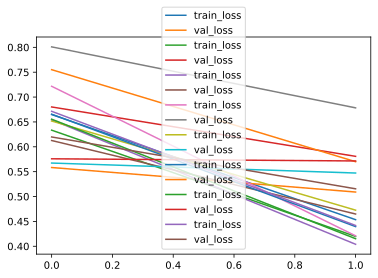

In [17]:
with open("./training_testing_results.csv", "w") as log_file:
    log_file.write("hidden_layer_size,dropout,int_precision,int_recall,int_fbeta,ext_precision,ext_recall,ext_fbeta\n")
    for n, model_params in enumerate(nn_params):
        print(n)
        # log_file.write(f"Model {n}\n")
        # log_file.write(f"Penalty: {model_params["penalty"]}, C: {model_params["C"]}\n")
        log_file.write(f"{model_params['layer_size']},{model_params['dropout']},")
        
        # first we create a model with one of the optimized parameter sets
        print("model fits")
        
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(200, )),
            tf.keras.layers.Dense(model_params["layer_size"], activation="relu"),
            tf.keras.layers.Dropout(model_params["dropout"]),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
        
        history = model.fit(x=x_train_scaled, 
                    y=y_train, 
                    batch_size=8, # change?
                    epochs=2, # change?
                    validation_split=0.05,
                    shuffle=True)
        
        plt.plot(history.epoch, history.history["loss"], label="train_loss")
        plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
        # plt.ylim(0, 1e9)
        # plt.xlim(0, 50)
        plt.legend()
        

        # then a model trained using these parameters is tested on the internal test set
        # I use the classes as predictions, because the confusion matrix is calculated like this
        # however, I think the production model should return probabilities
        model_predictions = model.predict(internal_x_test)
        model_predictions = np.array([0 if i <= 0.5 else 1 for i in model_predictions])
        print("model predicted")

        # the values of the testing on the internal test set are then used to select the best model
        # ? which <average> to select?? 
        # selected micro, idk why
        precision, recall, fbeta, support = precision_recall_fscore_support(internal_y_test, model_predictions, average='micro')
        log_file.write(f"{precision},{recall},{fbeta},")
        
        print("int stats calculated")

        # then the model is tested on an external test set to assess its "real" performance
        model_predictions_for_external = model.predict(external_x_test)
        model_predictions_for_external = np.array([0 if i <= 0.5 else 1 for i in model_predictions_for_external])
        ext_precision, ext_recall, ext_fbeta, ext_support = precision_recall_fscore_support(external_y_test, model_predictions_for_external, average='micro')
        print("ext stats calculated")
        log_file.write(f"{ext_precision},{ext_recall},{ext_fbeta}\n")